## Plots for l'Aquila
### Using: EPOS-LHC AixNet test data set
This notebook produces all the necessary plots for l'Aquila. Since there is no EPOS-LHC data set ready, as a preliminary result the test data set for AixNet will be used.

### Evaluating best dipole parameters

In [8]:
from simulated_dipole import *
import matplotlib.pyplot as plt


# calling the class for dipole parameters
dp = dipole_parameters('EPOS', 3, 1000) # which model, which dmax, how many steps 
res, d, beta = dp.evaluate() # results to plot, optimal dipole amplitude, optimal beta


Model chosen: EPOS
dipole cutoff: 3
Number of energy steps in integration: 1000
Best parameter evaluation ...
 progress: 100.0 %
 Best d_r: [0.0017]
Best beta_r: [2.1]


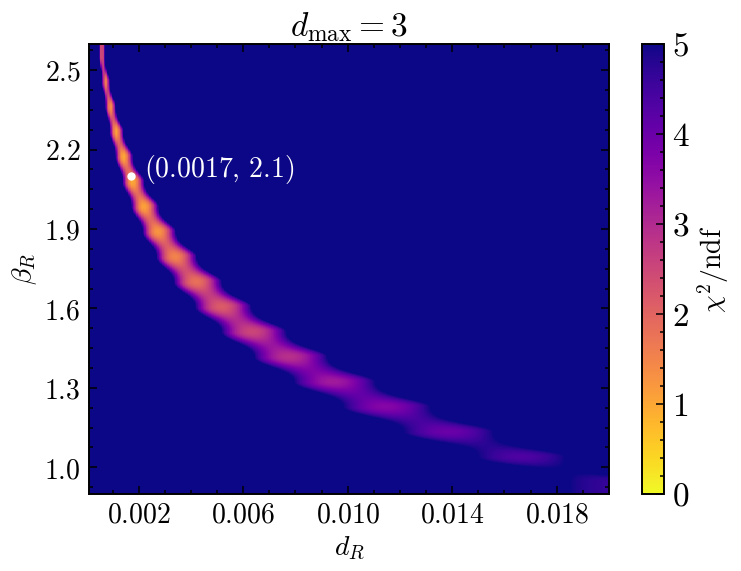

In [9]:
uni_d_r = np.unique(res['d_r'])
uni_beta_r = np.unique(res['beta_r'][(res['beta_r']>0.8)*((res['beta_r']<=2.6))])

grid = np.zeros((len(uni_beta_r), len(uni_d_r)))

for i, h in enumerate(uni_beta_r):
    for j, l in enumerate(uni_d_r):
        mask = (res['beta_r']==h) & (res['d_r']==l)
        if np.any(mask):
            grid[i, j] = res['chisq'][mask][0]


plt.figure(figsize=(10, 6))
plt.title(r'$d_\mathrm{max}=3$')
cmap = plt.cm.plasma_r
plt.imshow((grid)/1, aspect='auto', origin='lower',
           extent=[uni_d_r.min(), uni_d_r.max(),
                    uni_beta_r.min(), uni_beta_r.max()],
            cmap=cmap, vmin=0, vmax=5)
dot_y = uni_beta_r[np.where(grid==np.min(grid))[0]][0]
dot_x = uni_d_r[np.where(grid==np.min(grid))[1]][0]
plt.plot(dot_x, dot_y, ls='', marker='o', color='w', markersize=5)
plt.text(dot_x+0.0005, dot_y, rf'$({float(dot_x):.4f},\, {float(dot_y):.1f})$', color='w')
plt.colorbar(label=r'$\chi^2/$ndf')
plt.xlabel(r'$d_R$')
plt.ylabel(r'$\beta_R$')
yticks = np.arange(1.0, 2.6, 0.3)
plt.yticks(yticks, size='medium')
xticks = np.arange(0.002, 0.021, 0.004)
plt.xticks(xticks, size='medium')
plt.show()

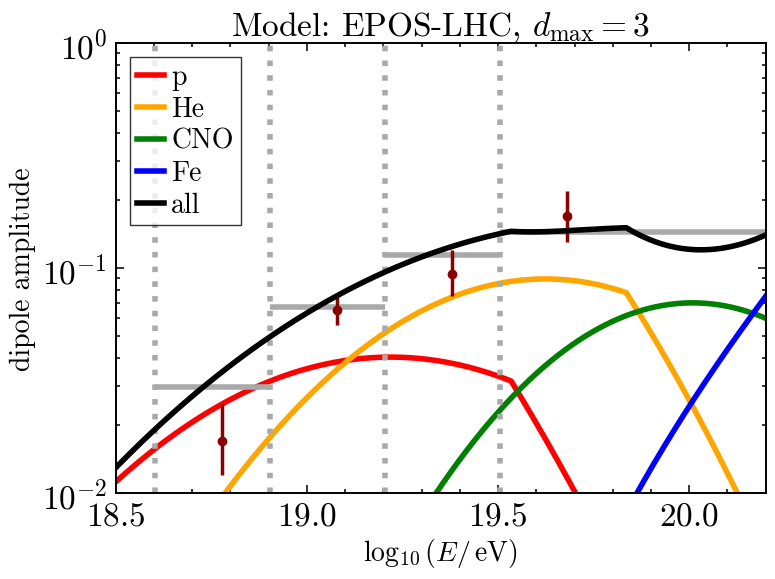

In [10]:
es = energy_spectrum()
dip = simulated_dipole(model='EPOS')
mf = mass_fractions(model='EPOS')

ene = np.linspace(np.log10(3e18),np.log10(200e18), num=1000)
dtot = np.zeros_like(ene)

plt.figure(figsize=(10,6))
plt.title(r'Model: EPOS-LHC, $d_\mathrm{max}=3$')
for name in names:
    if name == 'Fe':
        ddd = dip.dipole_dependence(name, np.power(10, ene - 18), 3)*(1 - (mf.fraction_func('p', ene) + mf.fraction_func('He', ene) + mf.fraction_func('CNO', ene)))
        plt.plot(ene, ddd, label=f'{name}', linewidth=4, color=colors[name])
        dtot += ddd
    else:
        ddd = dip.dipole_dependence(name, np.power(10, ene - 18), 3)*mf.fraction_func(name, ene)
        plt.plot(ene, ddd, label=f'{name}', linewidth=4, color=colors[name])
        dtot += ddd
for i in range(len(energies[:-1])):
    E = energies[i]
    Eplus = energies[i+1]
    enetwo = np.linspace(E, Eplus)
    Z_sum = np.zeros_like(enetwo)
    for name in charges:
        if name == 'Fe':
            Z_sum += dip.dipole_dependence(name, enetwo/1e18, 3)*(1 - (mf.fraction_func('p', np.log10(enetwo)) + mf.fraction_func('He', np.log10(enetwo)) + mf.fraction_func('CNO', np.log10(enetwo))))
        else:
            Z_sum += dip.dipole_dependence(name, enetwo/1e18, 3)*mf.fraction_func(name, np.log10(enetwo))
    plt.hlines(np.sum(es.spectrum_func_simpl(enetwo/1e18)*Z_sum)/np.sum(es.spectrum_func_simpl(enetwo/1e18)), np.log10(E), np.log10(Eplus),lw=4, color='darkgrey')
    plt.axvline(np.log10(E), lw=4, color='darkgrey', ls=':')
plt.errorbar(np.log10(1.5*mid_ene), dipole_values, yerr=dipole_errors, ls='', marker='o', color='darkred')
plt.plot(ene, dtot, label='all', linewidth=4, color='k')
plt.xlabel(r'$\log_{10}(E/\, \mathrm{eV})$')
plt.ylabel('dipole amplitude')
plt.ylim(1e-2, 1)
plt.xlim(18.5, 20.2)
plt.yscale('log')
plt.legend(loc='upper left')
plt.show()

### Example of cuts estimation on a simulated sample

['dnn_axis', 'dnn_core', 'dnn_energy', 'dnn_xmax', 'event_id', 'auger_id', 'sd_id', 'is_saturated', 'core', 'axis', 'energy', 'xmax', 'element', 'mass', 'merit', 'fd_energy', 'fd_axis', 'sd_energy', 'sd_axis', 'sd_galactic_latitude', 'sd_galactic_longitude', 'sd_core', 'univ_energy', 'univ_axis', 'delta_mean_delta', 'delta_xmax', 'delta_energy', 'muon_number']
51413


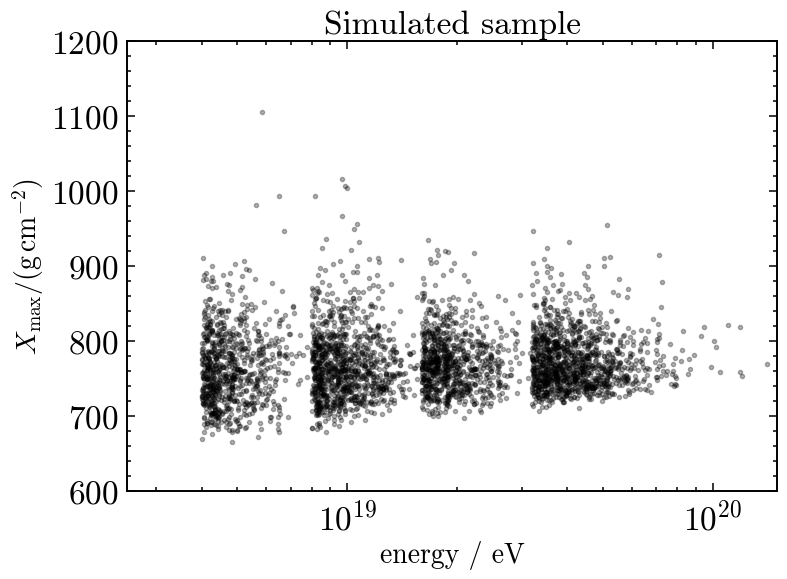

Remaining events above 8 EeV: 2998


In [11]:
dd = file_loader('AixNet_EPOS_test')

mass_mask = mf.extract_all_fractions(np.log10(dd['energy'])+18, dd['mass']) 
dd = dict_cutter(dd, mass_mask)

temp_dict = [{} for i in range(4)]
for i in range(len(energies[:-1])):
    enne = energies[i]/1e18
    enneplus = energies[i+1]/1e18
    energy_mask = (dd['energy']>=enne)&(dd['energy']<enneplus)
    temp_dict[i] = dict_cutter(dd, energy_mask)
    spectrum_mask = es.spectrum_fraction(temp_dict[i]['energy'])
    temp_dict[i] = dict_cutter(temp_dict[i], spectrum_mask)

dd = dict_paster(temp_dict)

dd['charge'] = np.empty_like(dd['mass'])
for mass in names:
    dd['charge'][np.where(dd['mass']==names[mass])]=charges[mass]

plt.figure(figsize=(10,6))
plt.title('Simulated sample')
plt.scatter(dd['energy']*1e18, dd['dnn_xmax'], alpha=0.3, color='k')
plt.xlabel(r'energy / eV')
plt.ylabel(r'$X_\mathrm{max} / \mathrm{(g \, cm^{-2})}$')
plt.xscale('log')
plt.ylim(600, 1200)
plt.xlim(2.5e18, 150e18)
plt.show()

print('Remaining events above 8 EeV:', len(dd['energy'][dd['energy']>=8]))

8.0 n= 999
16.0 n= 823
32.0 n= 1176


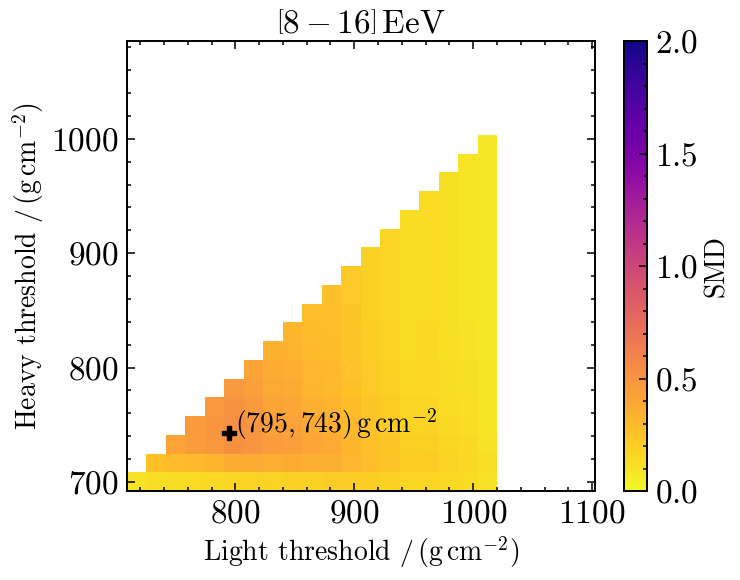

light fraction: [0.24624625]
heavy fraction: [0.32032032]


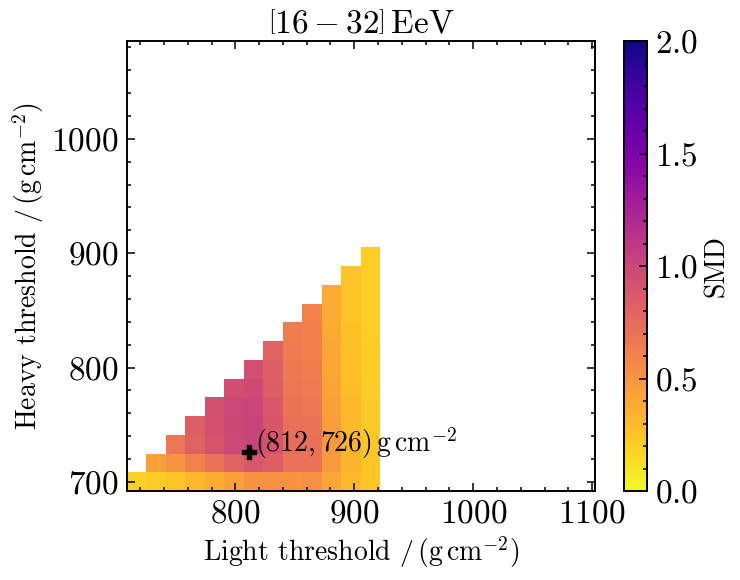

light fraction: [0.08383961]
heavy fraction: [0.23329283]


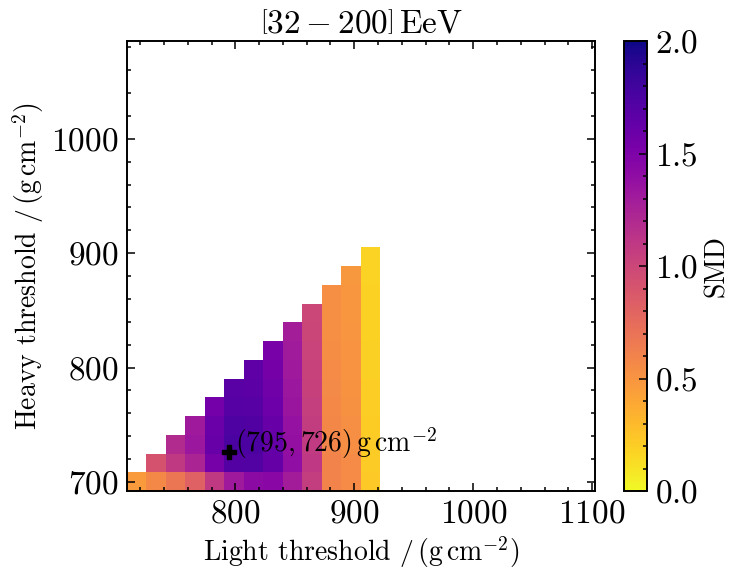

light fraction: [0.07568027]
heavy fraction: [0.44472789]


In [12]:
energies = np.array([8e18, 16e18, 32e18, 200e18])
smd = SMD_method()
generate_xmax19(dd, 'dnn_xmax', 'energy')

thres_values = np.linspace(np.min(dd['xmax19']), np.max(dd['xmax19']), 27)
# print(thres_values)
results_dict = {'emin': [], 
                'emax': [], 
                'light': [], 
                'heavy': [], 
                'N_light': [],
                'N_heavy': [],
                'N_tot': [],
                'SMD': [], 
                'lnA_light': [],
                'lnA_heavy': []
                }

for ee in range(len(energies)-1):
    e_min = energies[ee]/1e18
    e_max =energies[ee+1]/1e18

    e_mask = (dd['energy']<e_max)&(dd['energy']>=e_min)
    data = dict_cutter(dd, e_mask)
    print(e_min, 'n=', len(data['energy']))

    for i in range(1, len(thres_values) - 2):
        thres_h = thres_values[i]

        for j in range(i + 1, len(thres_values) - 1):

            thres_l = thres_values[j]
            mask_h = (data['xmax19']<thres_h)
            mask_l = (data['xmax19']>thres_l)
            light_frac = dict_cutter(data, mask_l)
            heavy_frac = dict_cutter(data, mask_h)

            value = smd.quantify_SMD(light_frac['energy'], light_frac['charge'], heavy_frac['energy'], heavy_frac['charge'], d_max=1)
            A_l = np.sum(np.log(light_frac['mass']))
            A_h = np.sum(np.log(heavy_frac['mass']))

            results_dict['emin'].append(e_min)
            results_dict['emax'].append(e_max)
            results_dict['light'].append(thres_l)
            results_dict['heavy'].append(thres_h)
            results_dict['SMD'].append(value)
            results_dict['N_light'].append(len(light_frac['xmax19']))
            results_dict['N_heavy'].append(len(heavy_frac['xmax19']))
            results_dict['N_tot'].append(len(data['xmax19']))
            results_dict['lnA_light'].append(A_l/len(data['xmax19']))
            results_dict['lnA_heavy'].append(A_h/len(data['xmax19']))



for key, value in results_dict.items():
    results_dict[key] = np.array(value)

for i in range(len(energies[:-1])):
    ene = energies[i]
    eneplus = energies[i+1]
    light_vals = np.array(results_dict['light'][results_dict['emin']==ene/1e18])
    heavy_vals = np.array(results_dict['heavy'][results_dict['emin']==ene/1e18])
    SMD_vals = np.array(results_dict['SMD'][results_dict['emin']==ene/1e18])
    # Create grid
    unique_light = np.unique(light_vals)  # Unique x values
    unique_heavy = np.unique(heavy_vals)  # Unique y values

    # Reshape SMD values into a 2D array
    SMD_grid = np.zeros((len(unique_heavy), len(unique_light)))

    for i, h in enumerate(unique_heavy):
        for j, l in enumerate(unique_light):
            mask = (heavy_vals == h) & (light_vals == l)
            if np.any(mask):
                SMD_grid[i, j] = SMD_vals[mask][0]  # Take first match

    masked_SMD = np.ma.masked_where((unique_light[None, :] <= unique_heavy[:, None])|(SMD_grid<=0), SMD_grid)
    # heatmap with absolute value
    plt.figure(figsize=(9, 6))
    plt.title(rf'$\left[{ene/1e18:.0f}-{eneplus/1e18:.0f} \right] \, \mathrm{{EeV}}$')
    cmap = plt.cm.plasma_r.copy()
    cmap.set_bad(color='white')  # Set masked values to white

    plt.imshow(masked_SMD, aspect='auto', origin='lower',
            extent=[unique_light.min(), unique_light.max(),
                    unique_heavy.min(), unique_heavy.max()],
            cmap=cmap, vmin=0, vmax=2)
    dot_x = (unique_light[np.where(SMD_grid==SMD_grid.max())[1]])[0]
    dot_y =  (unique_heavy[np.where(SMD_grid==SMD_grid.max())[0]])[0]
    plt.text(dot_x+5, dot_y, rf'$({float(dot_x):.0f},{float(dot_y):.0f}) \, \mathrm{{g \, cm^{{-2}}}}$')
    plt.plot(dot_x, dot_y, ls='', marker='P', color='k', markersize=10)
    plt.colorbar(label='SMD')
    plt.xlabel(r'Light threshold $/ \, \mathrm{(g \, cm^{-2})}$')
    plt.ylabel(r'Heavy threshold $/ \, \mathrm{(g \, cm^{-2})}$')
    plt.show()

    best_pos = np.where((results_dict['light']==dot_x)&(results_dict['heavy']==dot_y)&(results_dict['emin']==ene/1e18))
    print('light fraction:', results_dict['N_light'][best_pos]/results_dict['N_tot'][best_pos])
    print('heavy fraction:', results_dict['N_heavy'][best_pos]/results_dict['N_tot'][best_pos])

### Cuts optimization

In [13]:
keys_to_extract = ['dnn_xmax', 'energy', 'mass'] # energy in EeV
ddd = file_loader('AixNet_EPOS_test') # remember to change also which key is used in `generate_xmax19()`


ddd = {kk: ddd[kk] for kk in keys_to_extract if kk in ddd} # to get a faster cycle
ddd = remove_nan_entries(ddd) # needed for KAne
ene_mask = (ddd['energy']>=8)
ddd = dict_cutter(ddd, ene_mask)
print(len(ddd['energy']))


print(ddd.keys())
print('Number of simulated events above 8 EeV:', len(ddd['energy']))


# All necessary items for random samples are here
n_samples = 100
# these are the starting seeds for all the random generators, that are fixed and each different
seed_2 = np.arange(2*n_samples,3*n_samples)
seed_3 = np.arange(3*n_samples,4*n_samples)

final_results = {'iter': [], 'emin': [], 'light': [], 'heavy': [], 'frac_l': [], 'frac_h': []}

for k in range(n_samples):

    print('Iteration:', k+1, ' of ', n_samples)
    dd = ddd # here I make a copy, so that I can modify it (ddd stays the same for all cycles)
    print('Original length:', len(dd['energy']))

    # extract mass fractions
    mf.seed = seed_2[k] # fix seed
    mass_mask = mf.extract_all_fractions(np.log10(dd['energy'])+18, dd['mass']) # log(E/eV) is needed here
    dd = dict_cutter(dd, mass_mask)
    print('After mass fractions:', len(dd['energy']))

    # extract spectrum (bin-wise)
    es.seed = seed_3[k] # fix seed
    temp_dict = [{} for i in range(3)]
    for i in range(len(energies[:-1])):
        enne = energies[i]/1e18
        enneplus = energies[i+1]/1e18
        energy_mask = (dd['energy']>=enne)&(dd['energy']<enneplus)
        temp_dict[i] = dict_cutter(dd, energy_mask)
        spectrum_mask = es.spectrum_fraction(temp_dict[i]['energy'])
        temp_dict[i] = dict_cutter(temp_dict[i], spectrum_mask)

    dd = dict_paster(temp_dict)
    print('After energy spectrum:', len(dd['energy']))

    # define charge
    dd['charge'] = np.empty_like(dd['mass'])
    for mass in names:
        dd['charge'][np.where(dd['mass']==names[mass])]=charges[mass]

    generate_xmax19(dd, 'dnn_xmax', 'energy')
    # generate_lnA(dd, 'univ_xmax', 'univ_rmu', 'energy') # ONLY WORKS WITH UNIVERSALITY
    
    # estimate best quantiles
    thres_values = np.linspace(np.min(dd['xmax19']), np.max(dd['xmax19']), 27) # 25 values + 2 border values
    # thres_values = np.linspace(np.min(dd['lnA']), np.max(dd['lnA']), 27) # 25 values + 2 border values
    # print(thres_values)
    res = { 'emin': [], 
            'light': [], 
            'heavy': [], 
            'N_light': [],
            'N_heavy': [],
            'N_tot': [],
            'SMD': [],
            }
    
    for ee in range(len(energies)-1):
        e_min = energies[ee]/1e18
        e_max =energies[ee+1]/1e18


        # extract energy range
        e_mask = (dd['energy']<e_max)&(dd['energy']>=e_min)
        data = dict_cutter(dd, e_mask)

        for i in range(1, len(thres_values) - 2):
            thres_h = thres_values[i]

            for j in range(i + 1, len(thres_values) - 1):

                thres_l = thres_values[j]
                mask_h = (data['xmax19']<thres_h)
                mask_l = (data['xmax19']>thres_l)
                # mask_h = (data['lnA']<thres_h)
                # mask_l = (data['lnA']>thres_l)
                light_frac = dict_cutter(data, mask_l)
                heavy_frac = dict_cutter(data, mask_h)

                value = smd.quantify_SMD(light_frac['energy'], light_frac['charge'], heavy_frac['energy'], heavy_frac['charge'], d_max=1)
                A_l = np.sum(np.log(light_frac['mass']))
                A_h = np.sum(np.log(heavy_frac['mass']))

                res['emin'].append(e_min)
                res['light'].append(thres_l)
                res['heavy'].append(thres_h)
                res['SMD'].append(value)
                res['N_light'].append(len(light_frac['xmax19']))
                res['N_heavy'].append(len(heavy_frac['xmax19']))
                res['N_tot'].append(len(data['xmax19']))

    for key, value in res.items():
        res[key] = np.array(value)

    # format final results
    for l in range(len(energies[:-1])):

        emin_val = energies[l] / 1e18
        mask = res['emin'] == emin_val

        smd_vals = res['SMD'][mask]
        max_pos = np.argmax(smd_vals)

        valid_indices = np.where(mask)[0]

        idx = valid_indices[max_pos]
        n_tot = res['N_tot'][idx]
        n_light = res['N_light'][idx]
        n_heavy = res['N_heavy'][idx]

        if n_tot == 0:
            print(f"[WARNING] Total events is zero for energy bin {emin_val:.2f} EeV (iteration {k})")
            frac_l = np.nan
            frac_h = np.nan
        else:
            frac_l = n_light / n_tot
            frac_h = n_heavy / n_tot

        final_results['iter'].append(k)
        final_results['emin'].append(emin_val)
        final_results['light'].append(res['light'][idx])
        final_results['heavy'].append(res['heavy'][idx])
        final_results['frac_l'].append(frac_l)
        final_results['frac_h'].append(frac_h)




# Convert to pandas DataFrame
df = pd.DataFrame(final_results)
display(df)

['dnn_axis', 'dnn_core', 'dnn_energy', 'dnn_xmax', 'event_id', 'auger_id', 'sd_id', 'is_saturated', 'core', 'axis', 'energy', 'xmax', 'element', 'mass', 'merit', 'fd_energy', 'fd_axis', 'sd_energy', 'sd_axis', 'sd_galactic_latitude', 'sd_galactic_longitude', 'sd_core', 'univ_energy', 'univ_axis', 'delta_mean_delta', 'delta_xmax', 'delta_energy', 'muon_number']
51413
39097
dict_keys(['dnn_xmax', 'energy', 'mass'])
Number of simulated events above 8 EeV: 39097
Iteration: 1  of  100
Original length: 39097
After mass fractions: 9682
After energy spectrum: 3022
Iteration: 2  of  100
Original length: 39097
After mass fractions: 9728
After energy spectrum: 2979
Iteration: 3  of  100
Original length: 39097
After mass fractions: 9593
After energy spectrum: 3028
Iteration: 4  of  100
Original length: 39097
After mass fractions: 9720
After energy spectrum: 3069
Iteration: 5  of  100
Original length: 39097
After mass fractions: 9664
After energy spectrum: 3024
Iteration: 6  of  100
Original length

,iter,emin,light,heavy,frac_l,frac_h
0,0,8.0,781.931396,751.761475,0.333333,0.402516
1,0,16.0,797.016357,766.846436,0.146532,0.661074
2,0,32.0,797.016357,721.591614,0.065588,0.393526
3,1,8.0,790.516357,752.259277,0.247120,0.409424
4,1,16.0,803.268677,752.259277,0.113295,0.523699
...,...,...,...,...,...,...
295,98,16.0,798.003723,747.805298,0.135193,0.488197
296,98,32.0,785.454102,710.156433,0.095318,0.241639
297,99,8.0,803.345459,732.343811,0.200962,0.199038
298,99,16.0,803.345459,732.343811,0.126697,0.297511


8 EeV heavy median: 742.57, 68% interval: [732.93, 752.57]
16 EeV heavy median: 748.59, 68% interval: [734.92, 755.02]
32 EeV heavy median: 724.92, 68% interval: [718.21, 733.04]


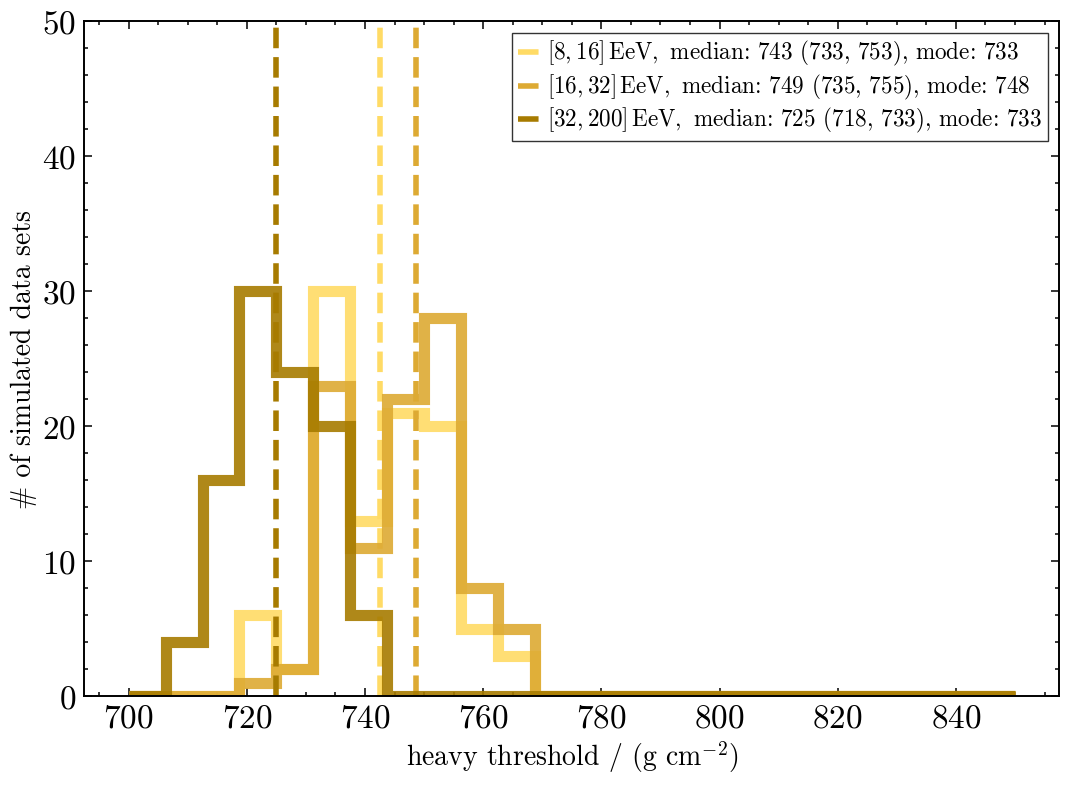

8 EeV light median: 797.96, 68% interval: [786.77, 813.30]
16 EeV light median: 800.46, 68% interval: [782.14, 810.11]
32 EeV light median: 790.71, 68% interval: [777.28, 797.70]


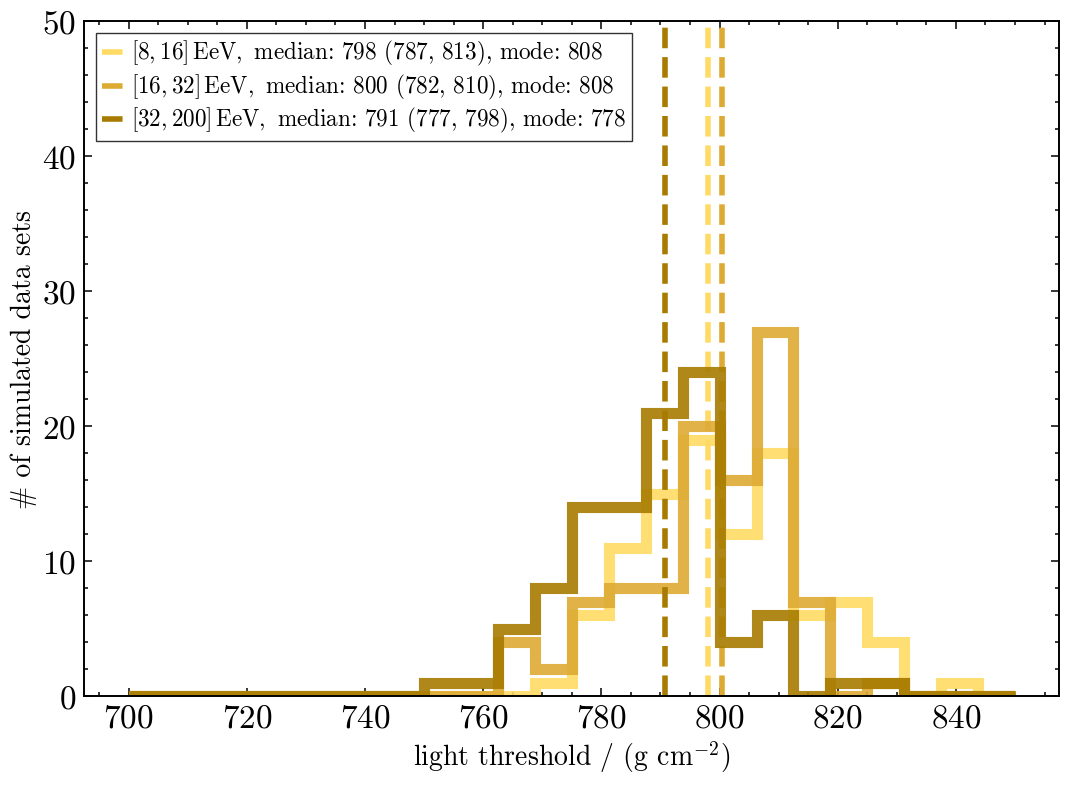

8 EeV heavy median: 0.32, 68% interval: [0.23, 0.41]
16 EeV heavy median: 0.49, 68% interval: [0.35, 0.56]
32 EeV heavy median: 0.43, 68% interval: [0.34, 0.51]


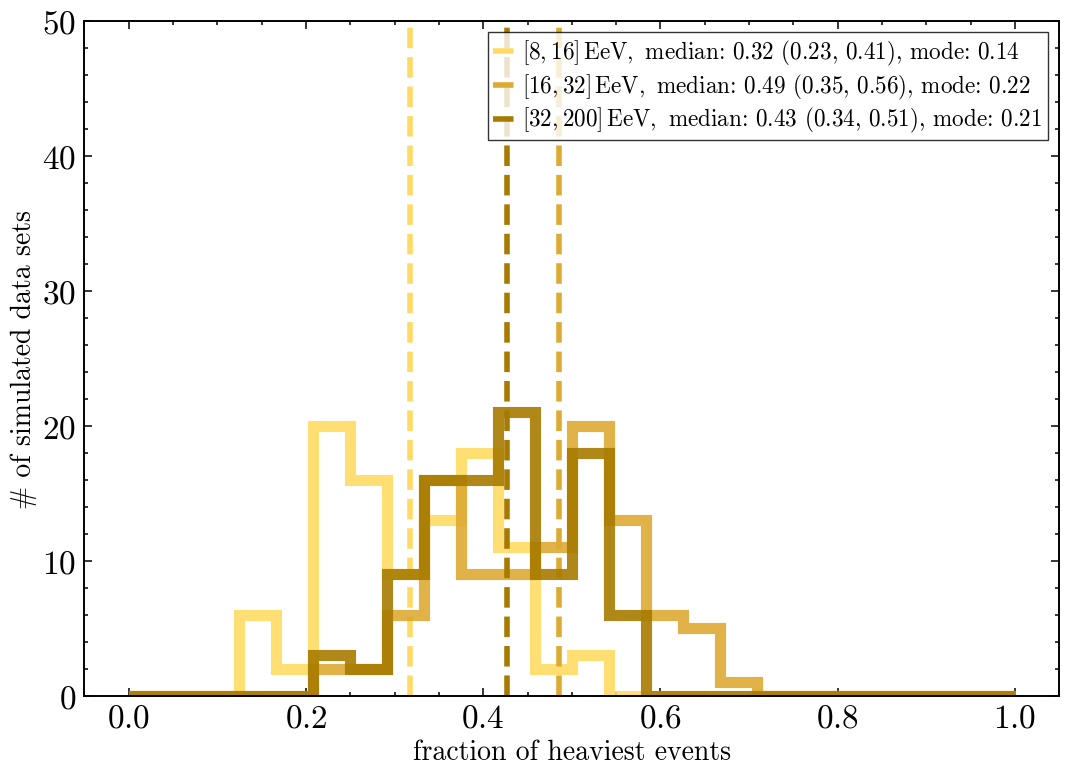

8 EeV light median: 0.22, 68% interval: [0.15, 0.29]
16 EeV light median: 0.13, 68% interval: [0.09, 0.22]
32 EeV light median: 0.08, 68% interval: [0.06, 0.14]


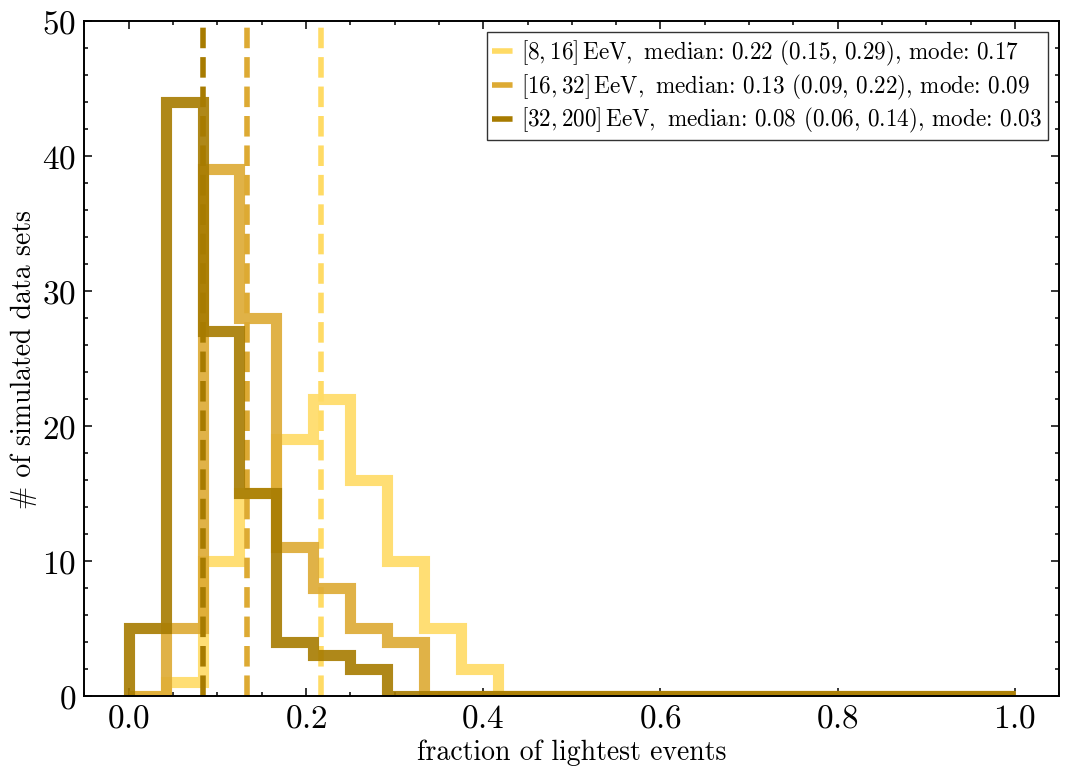

In [14]:
from scipy import stats

colors ={'8': '#ffdb65', '16': '#ddaa33', '32': '#a77b00'} # AixNet

energ = [8, 16, 32, 200]
bins = np.linspace(700, 850, num=25)

plt.figure(figsize=(15,9))
for i in range(len(energ[:-1])):
    ene = energ[i]
    data = df['heavy'][df['emin'] == ene]
    median = np.median(data)
    mode = stats.mode(data)
    p16, p84 = np.percentile(data, [16, 84])
    
    plt.hist(data, histtype='step', fill=False, color=colors[f'{ene}'], lw=8, alpha=0.9, bins=bins)
    plt.axvline(median, ls='--', lw=4, label=rf'$[{ene}, {energ[i+1]}] \, \mathrm{{EeV}},$ median: {median:.0f} ({p16:.0f}, {p84:.0f}), mode: {mode[0]:.0f}', color=colors[f'{ene}'])
    # plt.fill_betweenx([0, plt.gca().get_ylim()[1]], p16, p84, color=colors[f'{ene}'], alpha=0.2)

    print(f"{ene} EeV heavy median: {median:.2f}, 68% interval: [{p16:.2f}, {p84:.2f}]")
plt.legend(fontsize='small')
plt.xlabel(r'heavy threshold / (g cm$^{-2}$)')
plt.ylabel('# of simulated data sets')
plt.ylim(0, 50)
plt.show()


plt.figure(figsize=(15,9))
for i in range(len(energ[:-1])):
    ene = energ[i]
    data = df['light'][df['emin'] == ene]
    median = np.median(data)
    mode = stats.mode(data)
    p16, p84 = np.percentile(data, [16, 84])
    
    plt.hist(data, histtype='step', stacked=False, fill=False, color=colors[f'{ene}'], lw=8, alpha=0.9, bins=bins)
    plt.axvline(median, ls='--', lw=4, label=rf'$[{ene}, {energ[i+1]}] \, \mathrm{{EeV}},$ median: {median:.0f} ({p16:.0f}, {p84:.0f}), mode: {mode[0]:.0f}', color=colors[f'{ene}'])
    # plt.fill_betweenx([0, plt.gca().get_ylim()[1]], p16, p84, color=colors[f'{ene}'], alpha=0.2)

    print(f"{ene} EeV light median: {median:.2f}, 68% interval: [{p16:.2f}, {p84:.2f}]")
plt.legend(fontsize='small', loc='upper left')
plt.xlabel(r'light threshold / (g cm$^{-2}$)')
plt.ylabel('# of simulated data sets')
plt.ylim(0, 50)
plt.show()

bins = np.linspace(0, 1, num=25)
# fig, ax = plt.subplots(1, 2, figsize=(18, 9), sharey=True)
# First subplot: light
plt.figure(figsize=(15, 9))
for i in range(len(energ[:-1])):
    ene = energ[i]
    data = df['frac_h'][df['emin'] == ene]
    median = np.median(data)
    mode = stats.mode(data)
    p16, p84 = np.percentile(data, [16, 84])
    
    plt.hist(data, histtype='step', fill=False, color=colors[f'{ene}'], lw=8, alpha=0.9, bins=bins)
    plt.axvline(median, ls='--', lw=4,
                  label=rf'$[{ene}, {energ[i+1]}] \, \mathrm{{EeV}},$ median: {median:.2f} ({p16:.2f}, {p84:.2f}), mode: {mode[0]:.2f}',
                  color=colors[f'{ene}'])
    print(f"{ene} EeV heavy median: {median:.2f}, 68% interval: [{p16:.2f}, {p84:.2f}]")

plt.legend(fontsize='small')
plt.xlabel(r'fraction of heaviest events')
plt.ylabel('# of simulated data sets')
plt.ylim(0, 50)
plt.show()
# ax[0].set_ylim(0, 0.7)

# Second subplot: heavy
plt.figure(figsize=(15, 9))
for i in range(len(energ[:-1])):
    ene = energ[i]
    data = df['frac_l'][df['emin'] == ene]
    median = np.median(data)
    mode = stats.mode(data)
    p16, p84 = np.percentile(data, [16, 84])
    
    plt.hist(data, histtype='step', stacked=False, fill=False, color=colors[f'{ene}'], lw=8, alpha=0.9, bins=bins)
    plt.axvline(median, ls='--', lw=4,
                  label=rf'$[{ene}, {energ[i+1]}] \, \mathrm{{EeV}},$ median: {median:.2f} ({p16:.2f}, {p84:.2f}), mode: {mode[0]:.2f}',
                  color=colors[f'{ene}'])
    print(f"{ene} EeV light median: {median:.2f}, 68% interval: [{p16:.2f}, {p84:.2f}]")

plt.legend(fontsize='small')
plt.xlabel(r'fraction of lightest events')
plt.ylabel('# of simulated data sets')
plt.ylim(0, 50)
plt.show()